# EMNIST Dataset

**Getting the data:**
 1. Download the EMNIST from https://www.nist.gov/itl/iad/image-group/emnist-dataset
 2. Uncompress the gzip file using `gunzip ` command
 
**Reference:** Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). "EMNIST: an extension of MNIST to handwritten letters". [link to arxiv](http://arxiv.org/abs/1702.05373)

## PyTorch data loader:

In [1]:
from torchvision import transforms as T
from torch.utils.data import Dataset
from PIL import Image
import torch
import os
import struct
import numpy as np

main_dir = './emnist/'

class EmnistDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""
    """Load EMNIST data from `path`"""
    def __init__(self, path, mode, transform=None):
        
        self.transform = transform
        labels_path = os.path.join(path, 'emnist-letters-{}-labels-idx1-ubyte'.format(mode))
        images_path = os.path.join(path, 'emnist-letters-{}-images-idx3-ubyte'.format(mode))
        
        with open(labels_path, 'rb') as lbpath:
            magic, n = struct.unpack('>II', lbpath.read(8))
            self.labels = np.fromfile(lbpath, dtype=np.uint8)

        with open(images_path, 'rb') as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
            self.images = np.fromfile(imgpath, dtype=np.uint8).reshape(-1, 28, 28)
            
        print(self.images.shape, self.labels.shape)

    def __getitem__(self, index):

        img = Image.fromarray(self.images[index].T)
        label = self.labels[index]
        
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.labels)

def get_loader(path, batch_size=32, mode='train', num_workers=1, shuffle=None):
    """Build and return a data loader."""

    transform = []
    if mode == 'train':
        transform.append(T.RandomRotation(degrees=15, expand=False))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    dataset = EmnistDataset(path=path, mode=mode, transform=transform)
    
    if shuffle is None:
        shuffle = mode == 'train'
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers)
    
    return data_loader

def denorm(x):
    return x/2 + 0.5

(124800, 28, 28) (124800,)
(20800, 28, 28) (20800,)
torch.Size([128, 1, 28, 28]) torch.Size([128]) torch.uint8


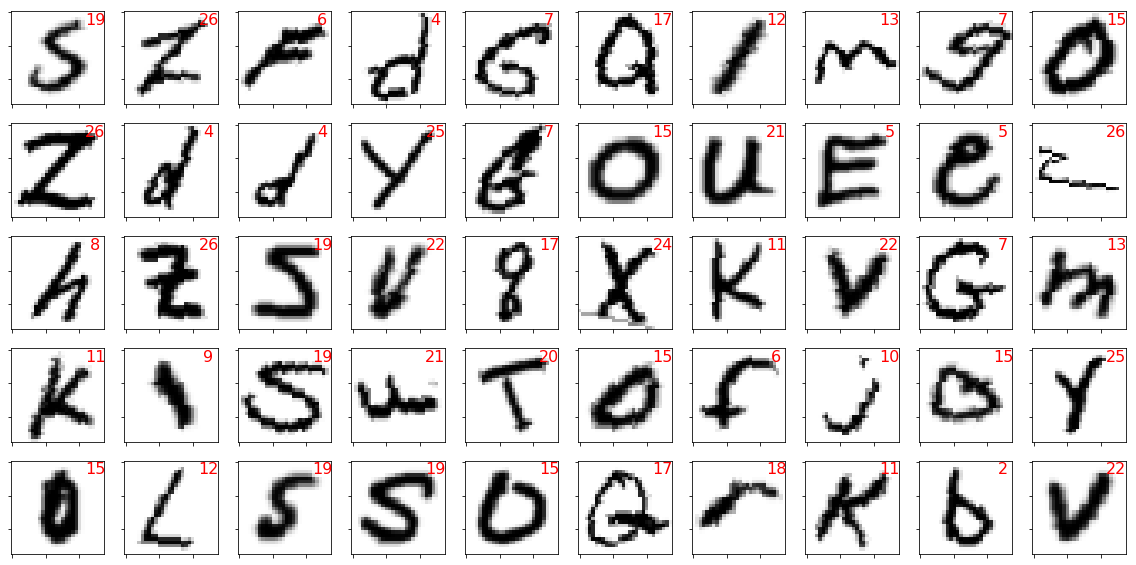

In [2]:
train_loader = get_loader(path=main_dir, batch_size=128, mode='train')
test_loader = get_loader(path=main_dir, batch_size=128, mode='test')

batch_x, batch_y = next(iter(train_loader))

print(batch_x.shape, batch_y.shape, batch_y.dtype)

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.imshow(denorm(batch_x[i, 0, :, :]).numpy(), cmap='binary')
    ax.text(0.9, 0.9, batch_y[i].item(), horizontalalignment='center', color='red', size=16,
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.show()